# AUTOENCODER


 - Practicum: [Week7](https://www.youtube.com/watch?v=bggWQ14DD9M&t=2529s) - [Instant](https://youtu.be/bggWQ14DD9M?t=2528) 

In this notewook, we are going to generate an AutoEncoder (AE), network with a encoder layer and a decoder layer.

![autoencoder](./res/autoencoder.png)


An AE takes a point in the original space (clean or with noise). Then, it represets the point in other point of the latent space (intermediate representational space). Finally, it reconstructs the point of the latent space to the original dimensionality space.

Now, we are working with points. In future lesssons, we will work with regions (no points) in the latent space.

We are going to work with the AutoEncoders (AE) types:

 - *Standard AE with under-complete hidden layer*: this model should be able to reconstruct the original point after represented it in smaller dimensionality latent space.  

 - *Denoising AE with over-complete hidden layer*: this model should be able to reconstruct the original point after added some noise and represented it in a bigger dimensionality latent space.  

In [ ]:
# Import some libraries

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

## Util functions

Image conversion routine. 

@alfredo: The data has the mean in the 0 and the range starts from -1 to +1. We concert it to put the mean in 0.5 and the range from 0 to 1.

In [ ]:
# Convert vector to image
def to_img(x):
    # Change the distribution
    x = 0.5 * (x + 1) 
    
    # Change the distribution
    x = x.view(x.size(0), 28, 28) #Images of 28*28 pixels = 784 pixels
    
    return x

Display routines

In [16]:
def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
    plt.show()

## Dataset

We are goint to use a dataset of images of hand writing numbers (MNIST database)

In [ ]:
# Define data loading step
batch_size = 256

- Define an image transformation process 

**Torchvision Transforms**: Transforms are common image transformations. They can be chained together using Compose. ([link](https://pytorch.org/docs/stable/torchvision/transforms.html))

In [5]:
# We define a transform
img_transform = transforms.Compose([
    transforms.ToTensor(),               # Convert image array to tensor
    transforms.Normalize((0.5,), (0.5,)) # Normalize: substract by 0.5 and divide by 0.5
])

- Dataset from MNIST database

The MNIST database of handwritten digits ([link](http://yann.lecun.com/exdb/mnist/)). We use the pytorch utilities to load this datset and apply the previous defined transformation.

In [6]:
dataset = MNIST('../data', transform=img_transform, download=True)

* Put the dataset in a data loader 

**torch.utils.data.DataLoader** is an iterator which provides:

     - Batching the data
     - Shuffling the data
     - Load the data in parallel using multiprocessing workers.

In [7]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Train Autoencoder

In [8]:
# Available device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We are going to use two different types of AutoEncoders (AE): Standard AE and Denoise AE. 

Both types can be trained using very similar code to train but with important differences. 

Now, we codifying the common class AE definition and reconstruction loss.

In [9]:
# Define model architecture and reconstruction loss

# n = 28 x 28 = 784

class Autoencoder(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, d), #input 784 to `d` neurons
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28), #latent `d` neurons to output 784 
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

We have images of 784 pixels (28x28 generated from the image convertor function).

We define a convolutional network with `d` dimensional intermidial hidden layer.

In [10]:
# Configure the loss
criterion = nn.MSELoss()

In [13]:
# Configure the optimiser
def get_model_optimiser(model):
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=learning_rate,
    )
    return optimizer

Now we are going to define and train the different AEs

### Standard AE (with under-complete hidden layer)

When dimensionality of the hidden layer is smaller than the size of the input we have an `under-complete hidden layer`. For example, `n=50 > d=10`.

![under-complete hidden layer schema](./res/under-complete_hidden_layer.png)

It can be used to "compression".

In [14]:
d = 30  # for standard AE (under-complete hidden layer)
    
model = Autoencoder(d).to(device)

optimizer = get_model_optimiser(model)

epoch [1/20], loss:0.0628


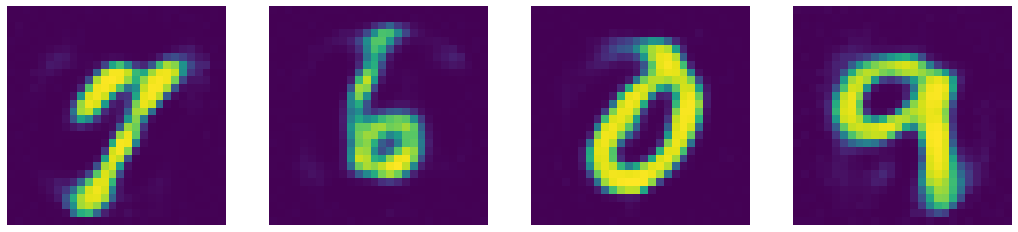

epoch [2/20], loss:0.0534


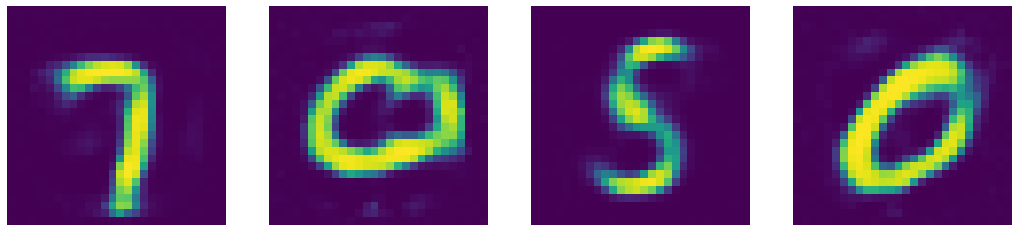

epoch [3/20], loss:0.0536


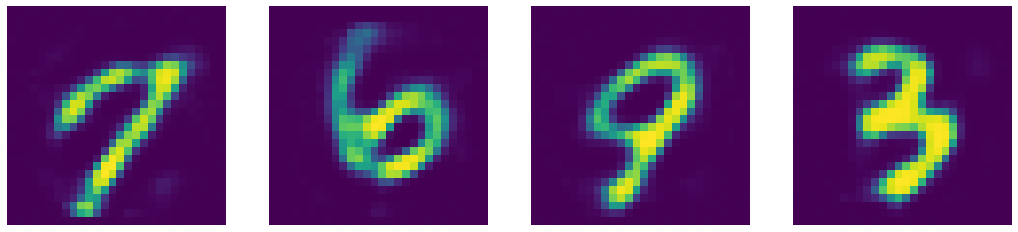

epoch [4/20], loss:0.0579


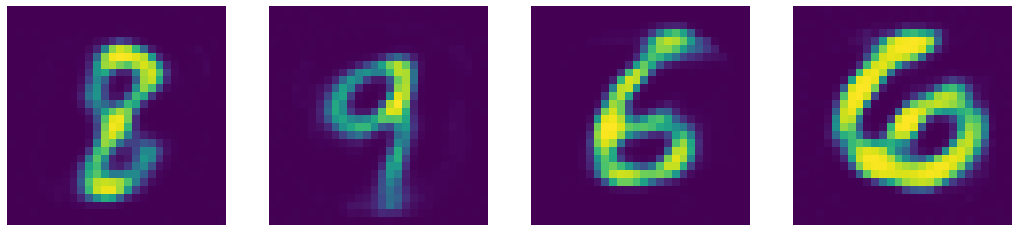

epoch [5/20], loss:0.0534


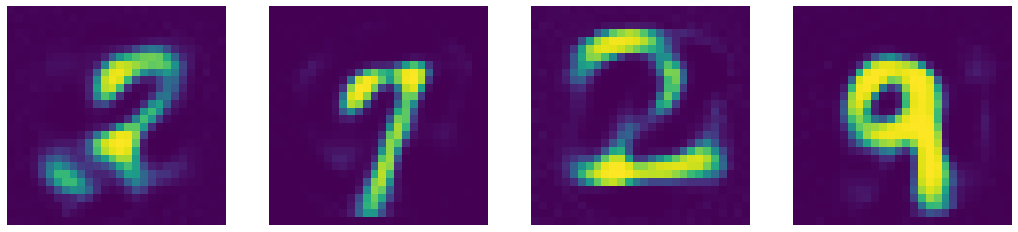

epoch [6/20], loss:0.0546


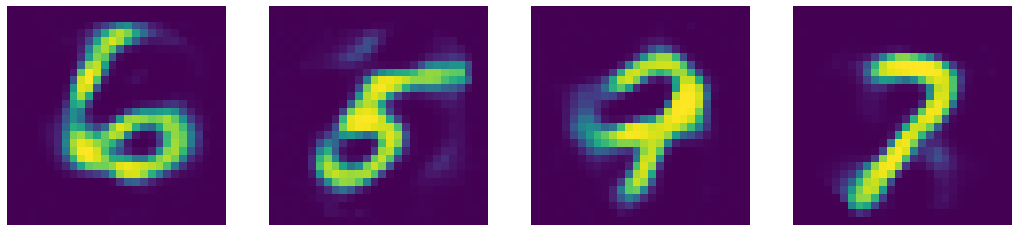

epoch [7/20], loss:0.0533


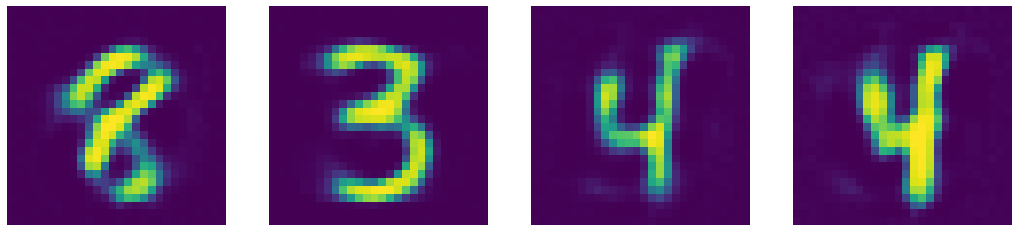

epoch [8/20], loss:0.0532


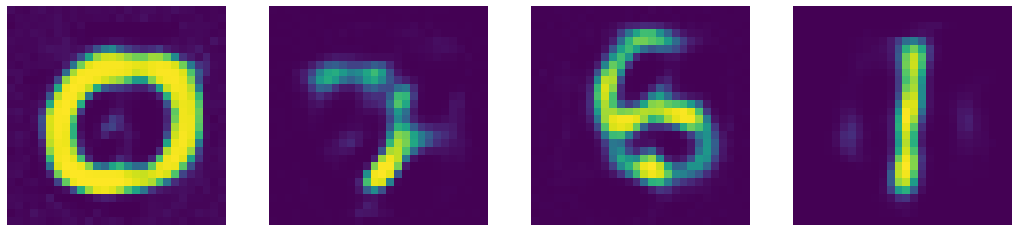

epoch [9/20], loss:0.0577


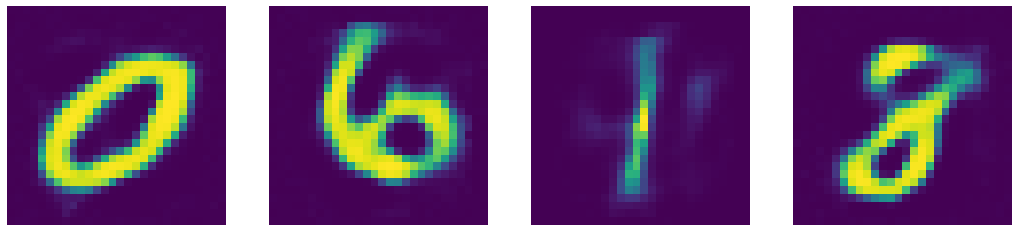

epoch [10/20], loss:0.0504


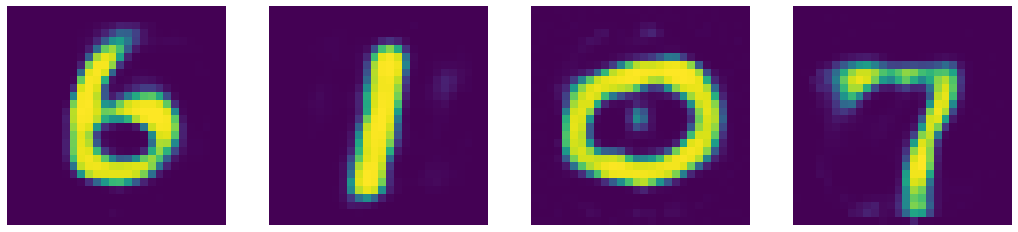

epoch [11/20], loss:0.0547


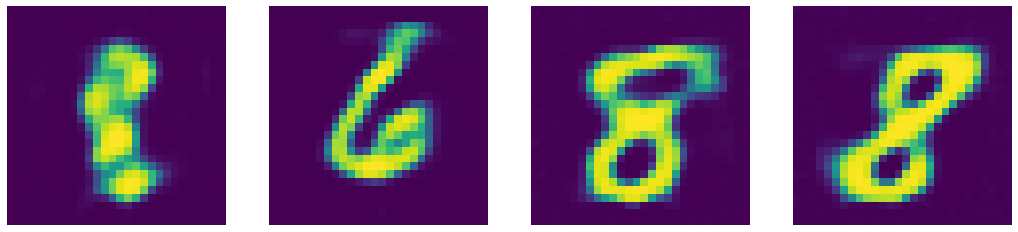

epoch [12/20], loss:0.0556


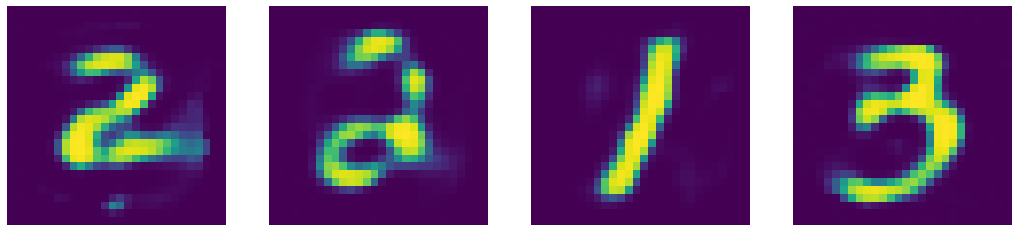

epoch [13/20], loss:0.0539


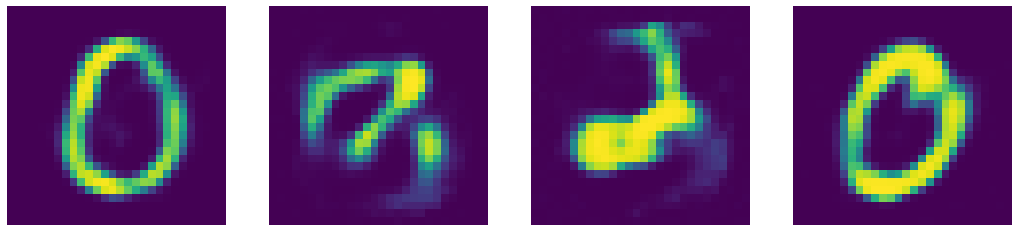

epoch [14/20], loss:0.0520


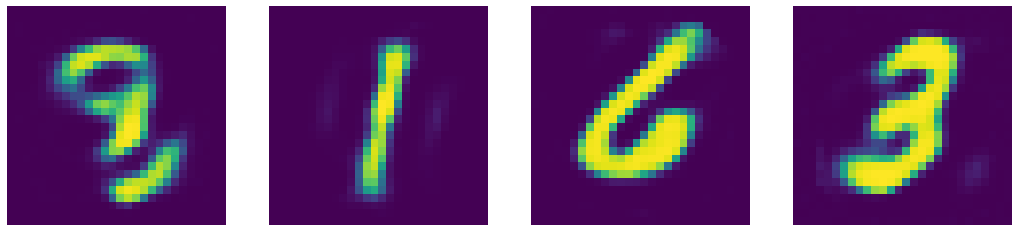

epoch [15/20], loss:0.0530


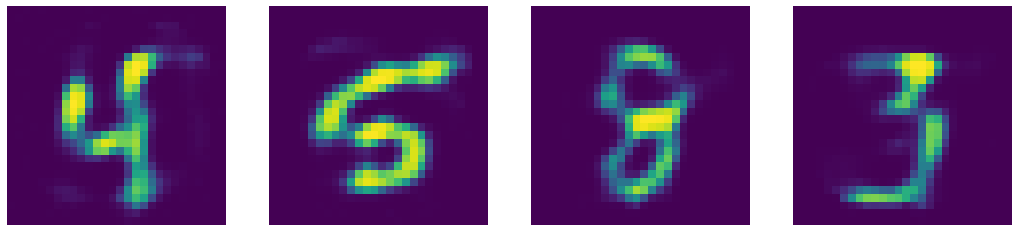

epoch [16/20], loss:0.0517


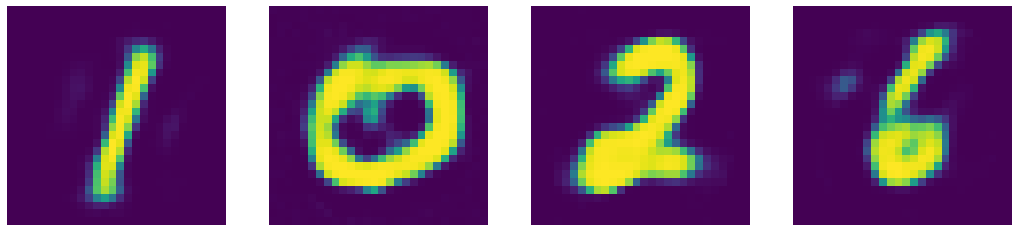

epoch [17/20], loss:0.0542


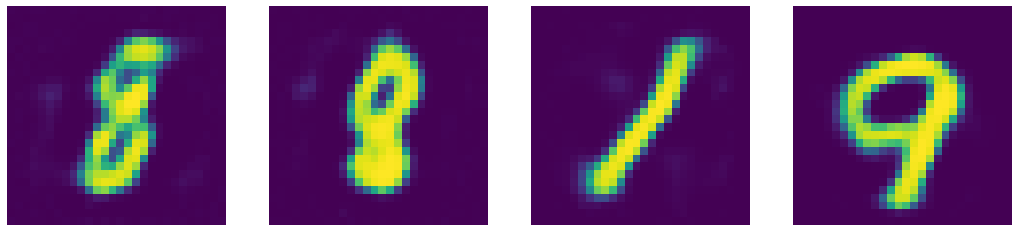

epoch [18/20], loss:0.0526


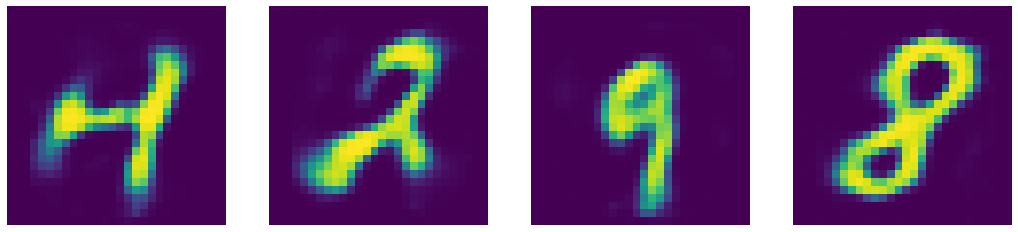

epoch [19/20], loss:0.0492


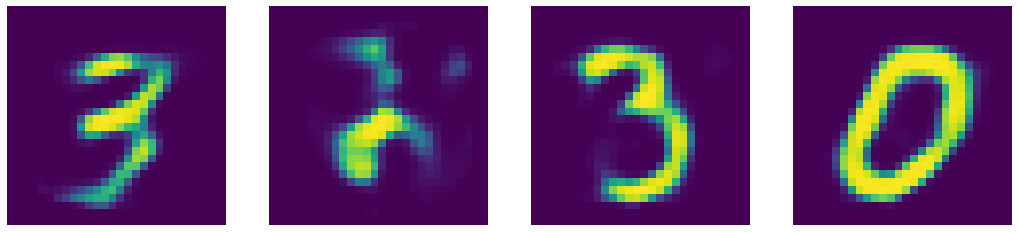

epoch [20/20], loss:0.0506


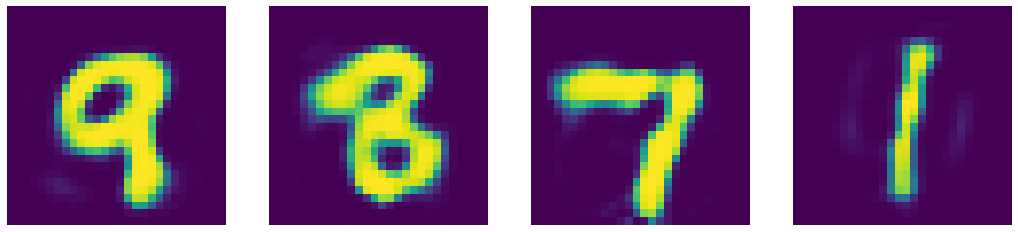

In [17]:
# Train standard 
num_epochs = 20
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        # ===================forward=====================
        output = model(img)  # feed <img> (for std AE) 
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, output)  # pass (None, output) for std AE

*Comment* or *un-comment out* a few lines of code to seamlessly switch between *standard AE* and *denoising one*.

Don't forget to **(1)** change the size of the hidden layer accordingly, **(2)** re-generate the model, and **(3)** re-pass the parameters to the optimiser.

In [ ]:
# Train standard or denoising autoencoder (AE)

num_epochs = 20
# do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        # noise = do(torch.ones(img.shape)).to(device)
        # img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = model(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

After training, we represent the final kernels of the encoder. This is, the rows of the W of the enconder.

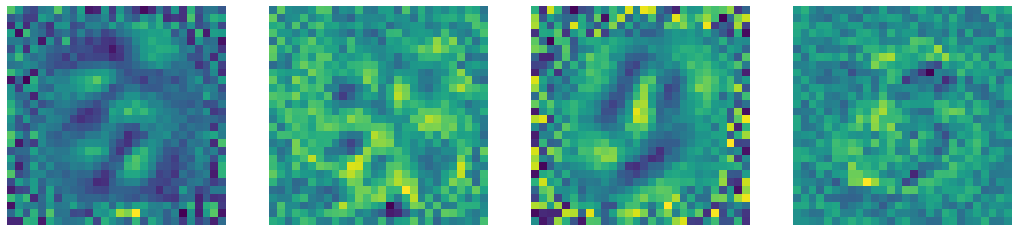

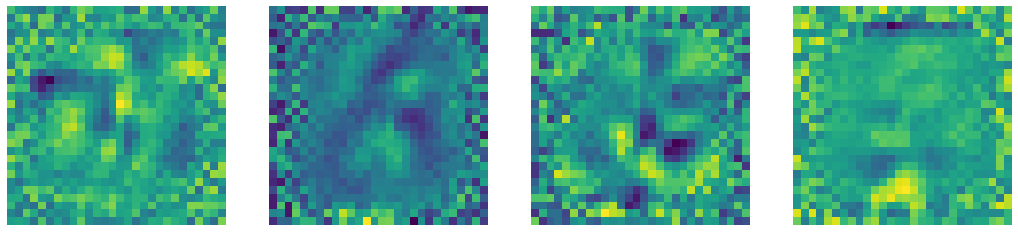

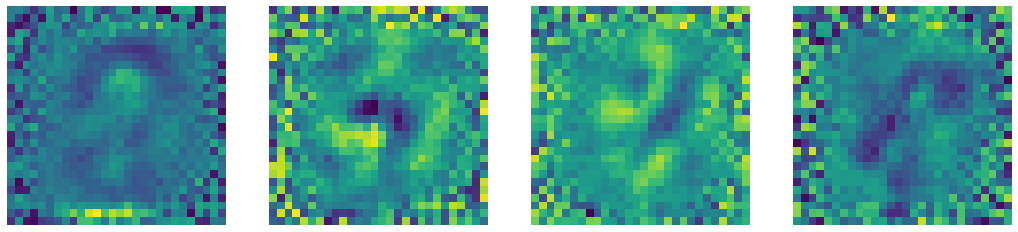

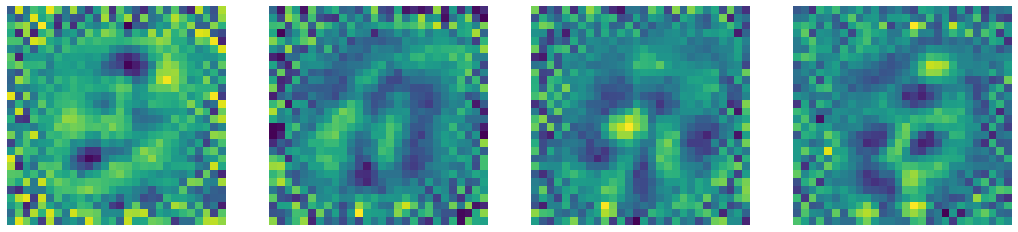

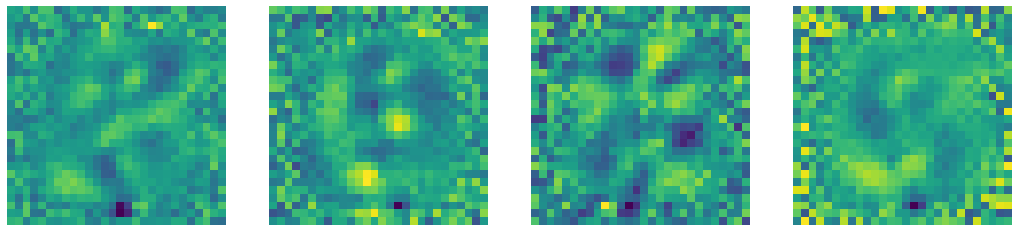

In [18]:
# Visualise a few kernels of the encoder

display_images(None, model.encoder[0].weight, 5)

This trained AE contains filters that allows you unroll the compress images. In this case, the contour pixels are not relevant (there is no noise for this there is no training examples with values outside of the central of the filter). In average, they don't contribute to the final score.

### Denoising AE (with over-complete hidden layer)

When dimensionality of the hidden layer is bigger than the size of the input we have an `over-complete hidden layer`. For example, `n=50 > d=100`.

![over-complete hidden layer schema](./res/over-complete_hidden_layer.png)

With a larger dimensional representation, the encoder can extract the more features possible of the input.

In a denoising AE you take a point of your training data. You add noise to this point. And you train the model to reconstruct the original point. At the end, the AE learns a verctor field that returns everything to some point of the training sample (it collapse towards the training manifold, in this way the model is insentive to this kind of perturbations).

![denoising autoencoder](./res/denoising_autoencoder.png)

If we don't include noise in the input images, at the end, the encoder and decoder would only learn the identity matrix.

In [19]:
d = 500  # for denoising AE (over-complete hidden layer)
    
model = Autoencoder(d).to(device)

optimizer = get_model_optimiser(model)

epoch [1/20], loss:0.0745


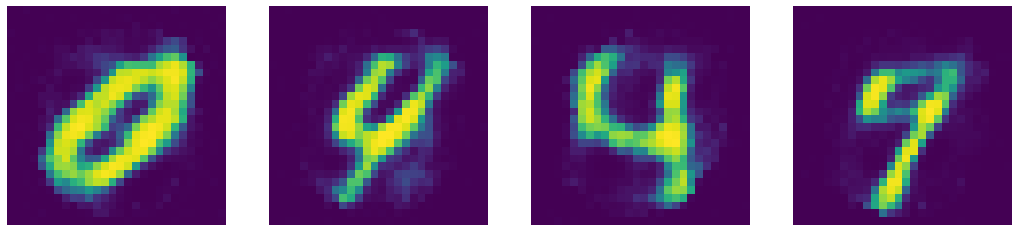

epoch [2/20], loss:0.0602


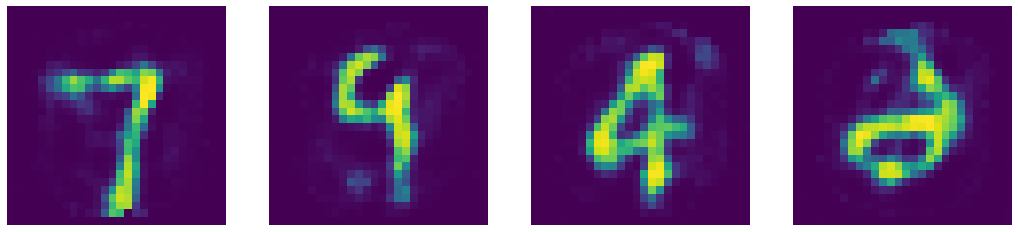

epoch [3/20], loss:0.0560


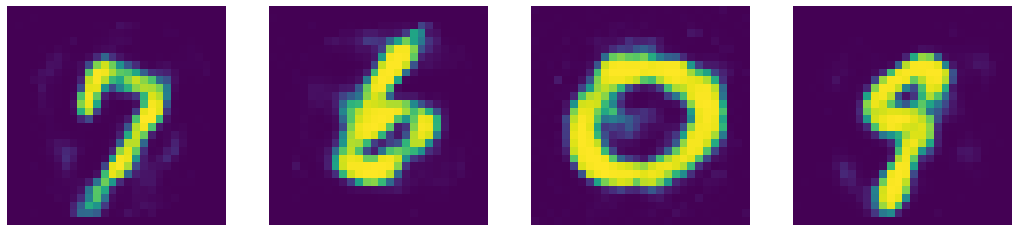

epoch [4/20], loss:0.0512


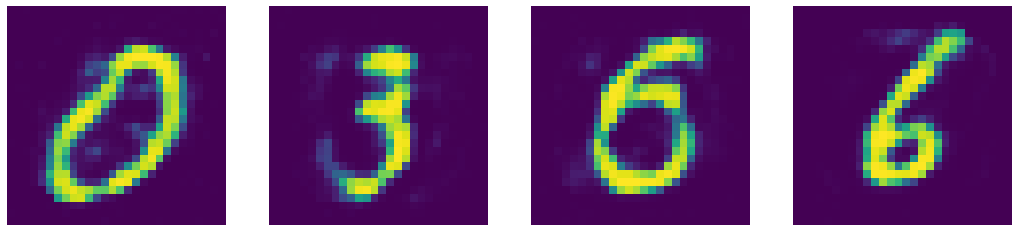

epoch [5/20], loss:0.0497


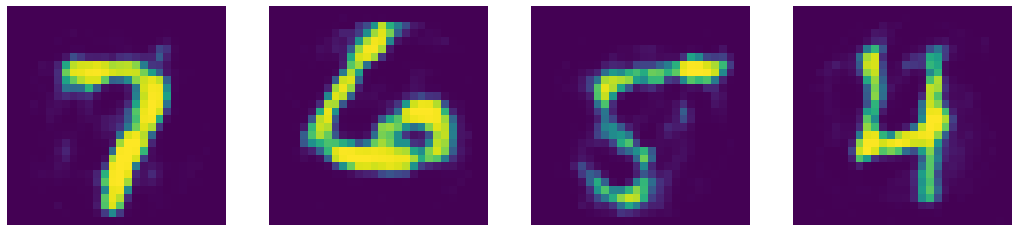

epoch [6/20], loss:0.0475


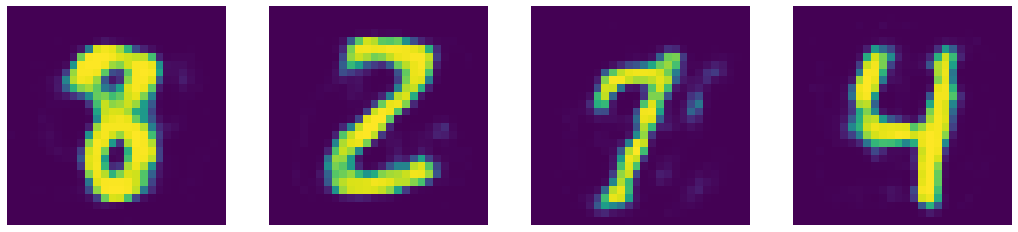

epoch [7/20], loss:0.0494


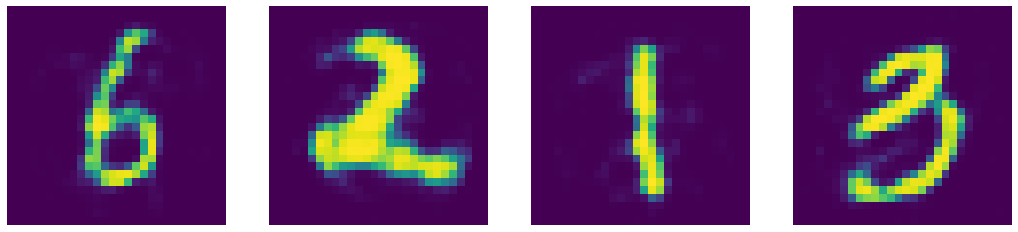

epoch [8/20], loss:0.0480


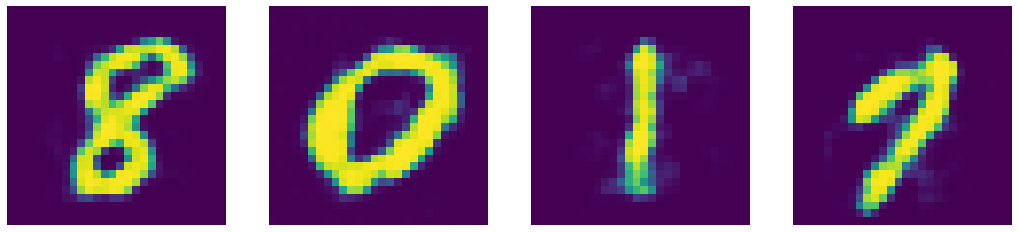

epoch [9/20], loss:0.0487


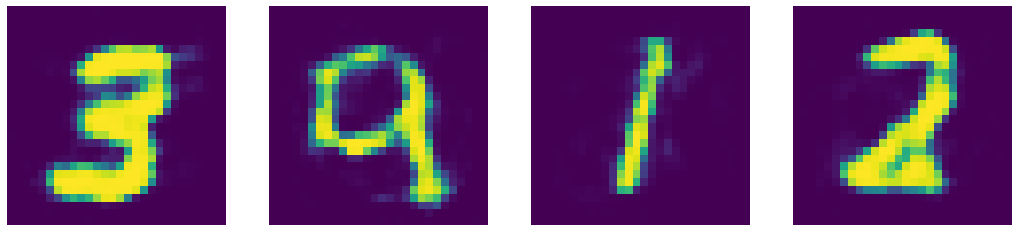

epoch [10/20], loss:0.0444


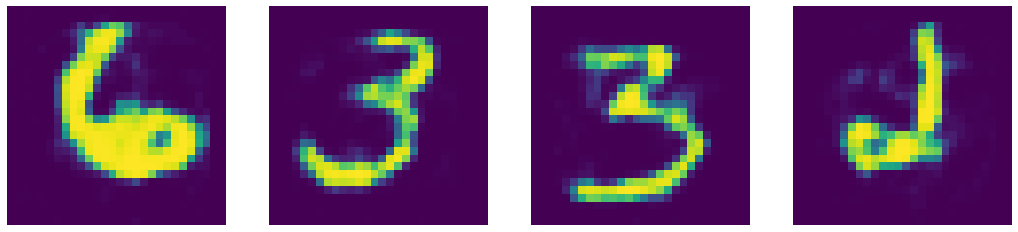

epoch [11/20], loss:0.0452


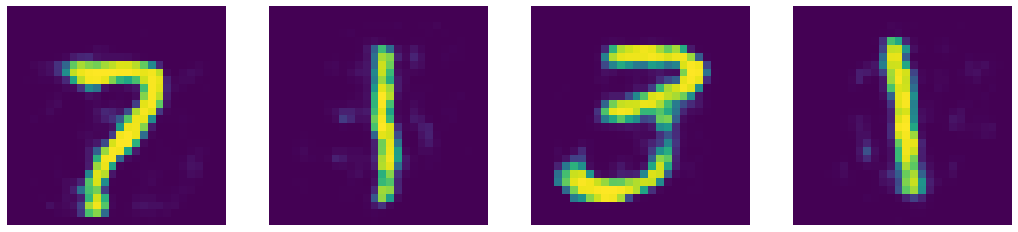

epoch [12/20], loss:0.0425


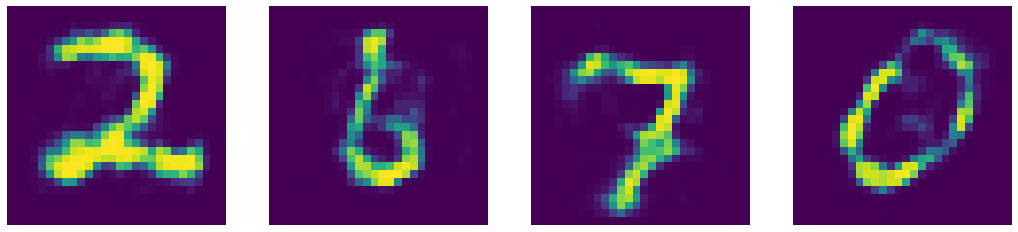

epoch [13/20], loss:0.0412


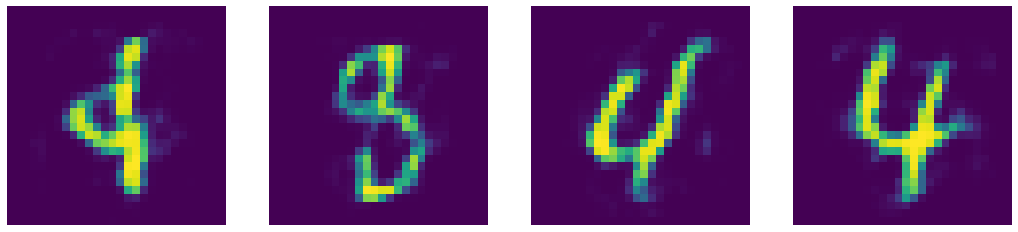

epoch [14/20], loss:0.0411


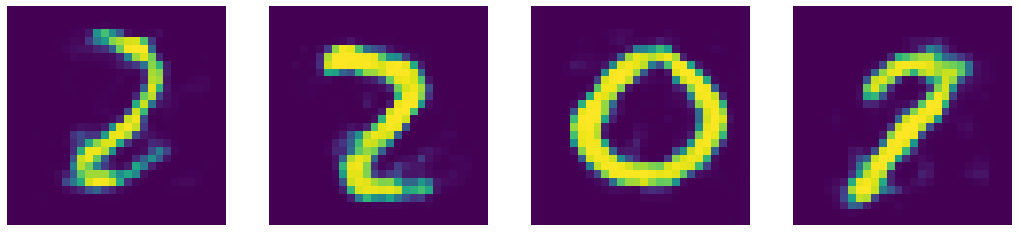

epoch [15/20], loss:0.0422


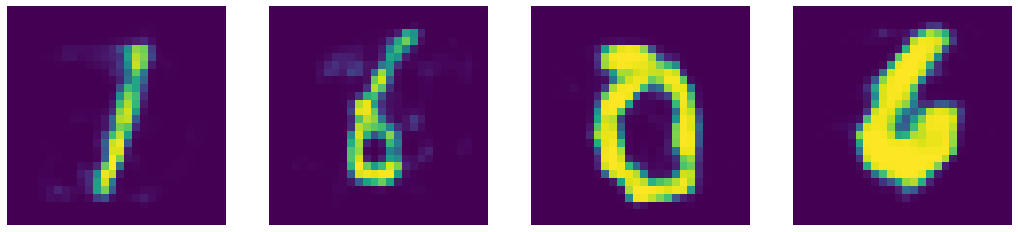

epoch [16/20], loss:0.0407


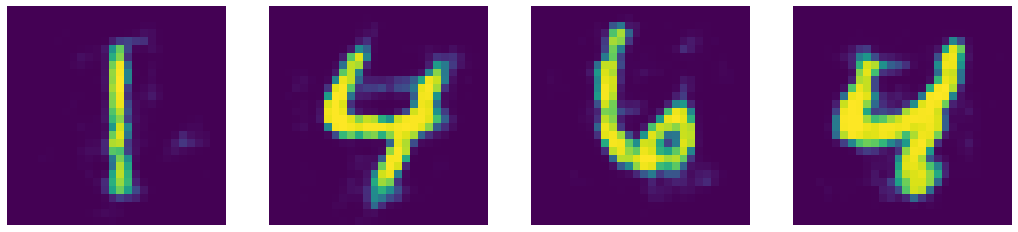

epoch [17/20], loss:0.0431


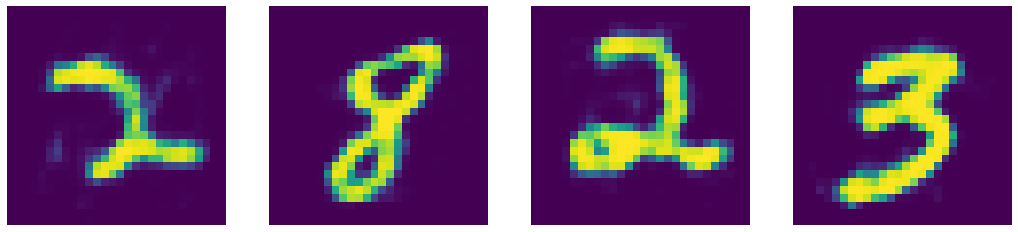

epoch [18/20], loss:0.0413


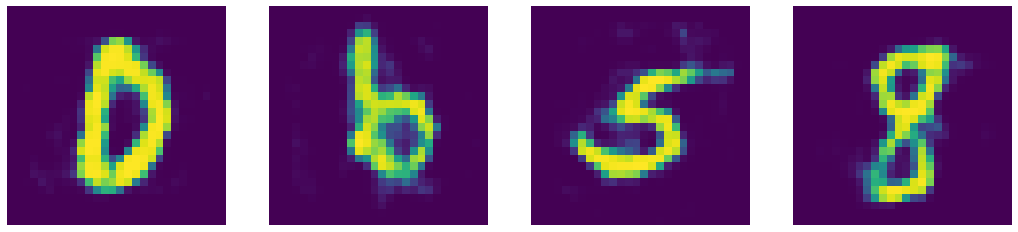

epoch [19/20], loss:0.0392


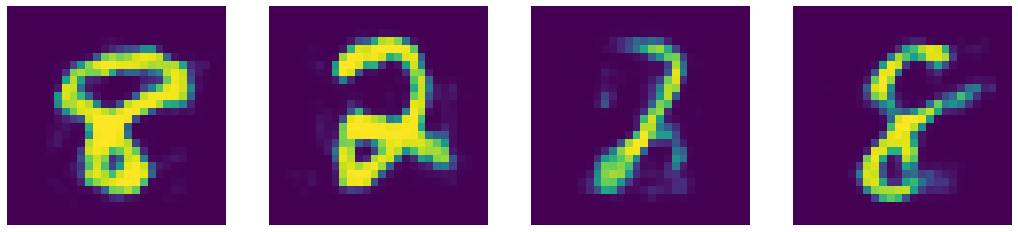

epoch [20/20], loss:0.0381


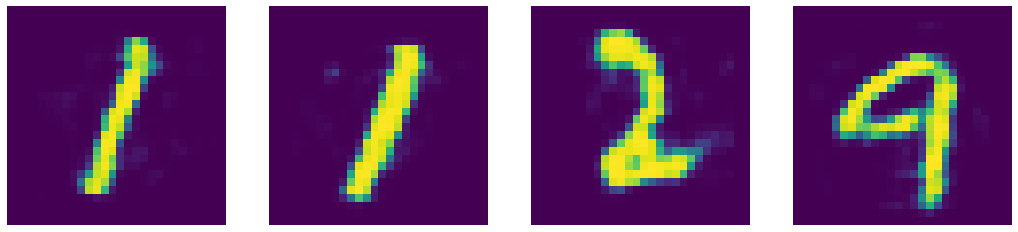

In [20]:
# Train denoising autoencoder (AE)

num_epochs = 20
do = nn.Dropout() # Allows introduce perturbation in the original images
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        
        # We add noise
        ## It generates a mask of 1 where the dropout isn't trigger and 0 where it is trigger
        noise = do(torch.ones(img.shape)).to(device)
        
        ## Then, if you multiply noise and image you get images with black dots
        img_bad = (img * noise).to(device)  # comment out for standard AE
        
        # ===================forward=====================
        output = model(img_bad)  # feed <img_bad> (for denoising AE)
        loss = criterion(output, img.data) # Loss with the original image (without noise)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

It seems representations more clean in this AE than in the previous. It should be because we are using a bigger dimensionality latent space.

After training, we represent the final kernels of the encoder. This is, the rows of the W of the enconder.

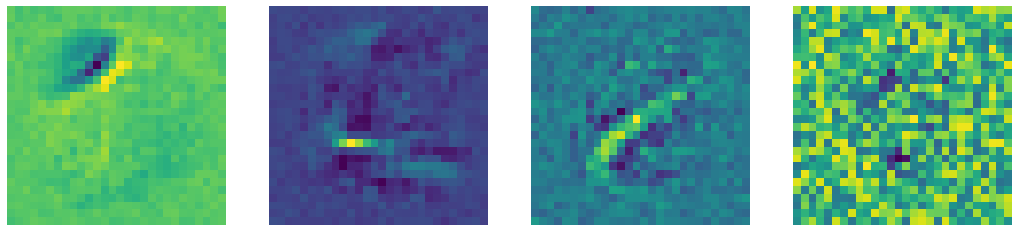

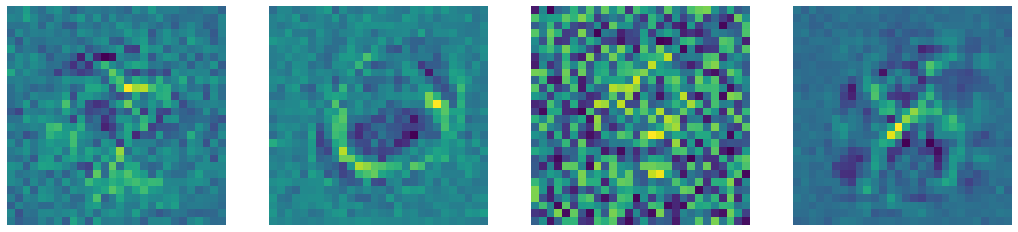

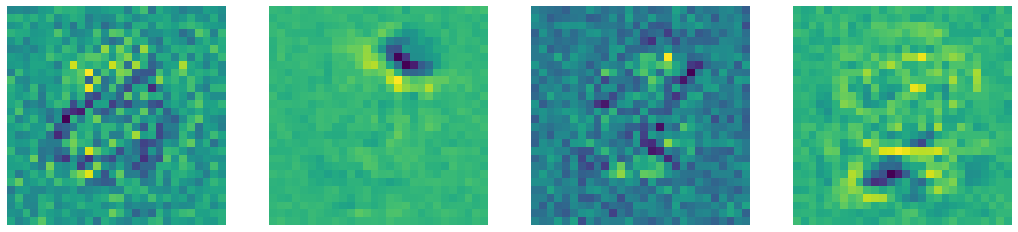

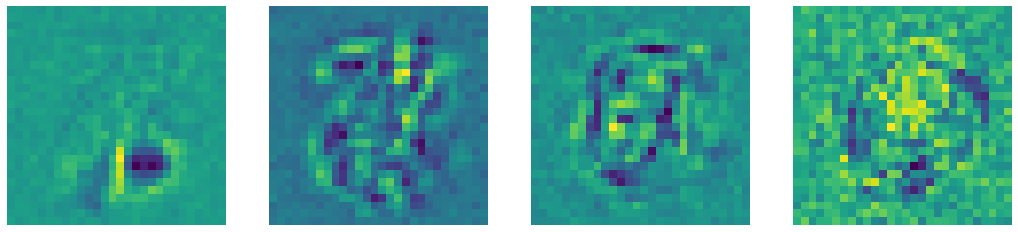

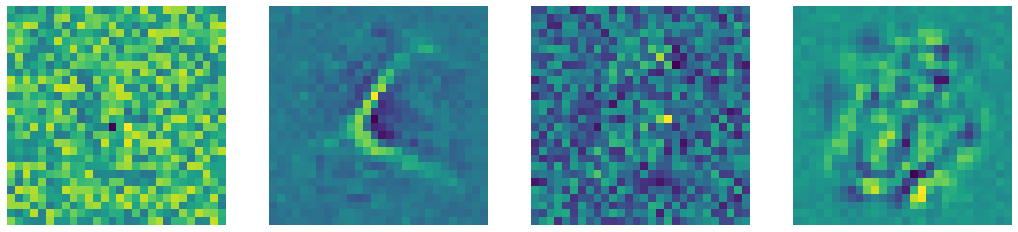

In [21]:
# Visualise a few kernels of the encoder

display_images(None, model.encoder[0].weight, 5)

In this AE the filters learns how collapse the contour points to the central representated pattern. The contour points matters. Some of them don't learn anything (random mixture of pixels). 

## Comparation between denoising AE and state of the art (SOTA) denoising algorithms 

This section should be executed only after having trained the Denoising AE.

We compare with inpaint ns and telea algorithms

In [27]:
# Let's compare the autoencoder inpainting capabilities vs. OpenCV
# RUN THIS ONLY AFTER HAVING TRAINED A DENOISING AE!!!

from cv2 import inpaint, INPAINT_NS, INPAINT_TELEA

In [28]:
# Inpaint with Telea and Navier-Stokes methods

dst_TELEA = list()
dst_NS = list()

for i in range(3, 7):
    corrupted_img = ((img_bad.data.cpu()[i].view(28, 28) / 4 + 0.5) * 255).byte().numpy()
    mask = 2 - noise.cpu()[i].view(28, 28).byte().numpy()
    dst_TELEA.append(inpaint(corrupted_img, mask, 3, INPAINT_TELEA))
    dst_NS.append(inpaint(corrupted_img, mask, 3, INPAINT_NS))

tns_TELEA = [torch.from_numpy(d) for d in dst_TELEA]
tns_NS = [torch.from_numpy(d) for d in dst_NS]

TELEA = torch.stack(tns_TELEA).float()
NS = torch.stack(tns_NS).float()

ORIGINAL IMAGE


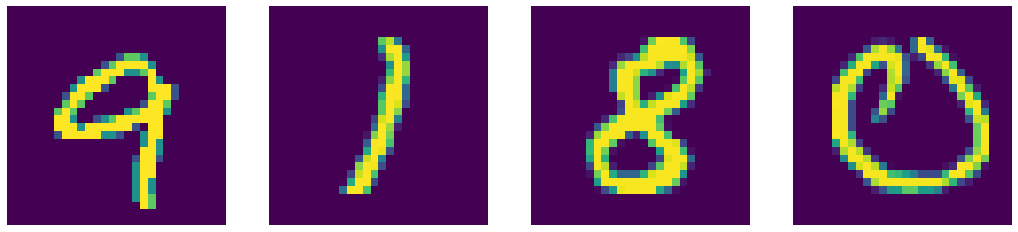

NOISE PATTERNS


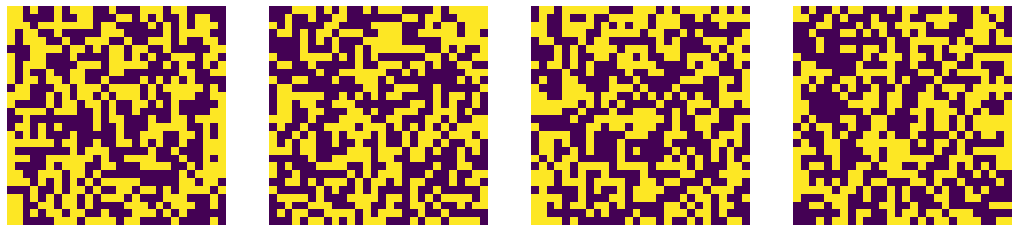

NOISY IMAGE


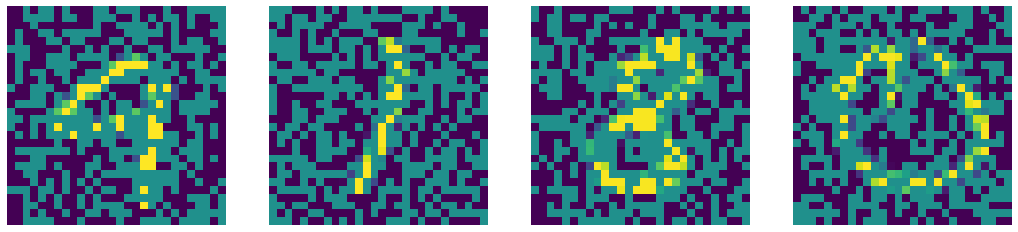


AE OUTPUT RECONSTRUCTED IMAGE


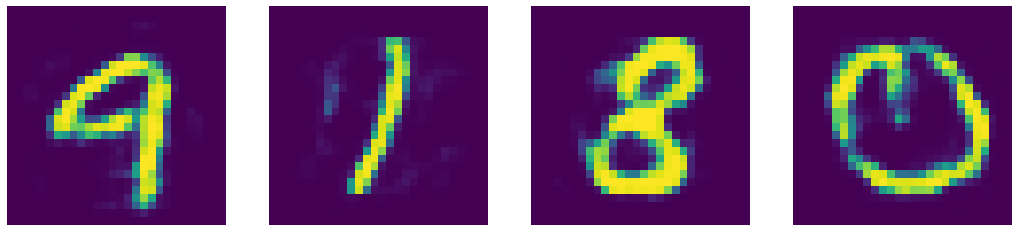


TELEA RECONSTRUCTED IMAGE


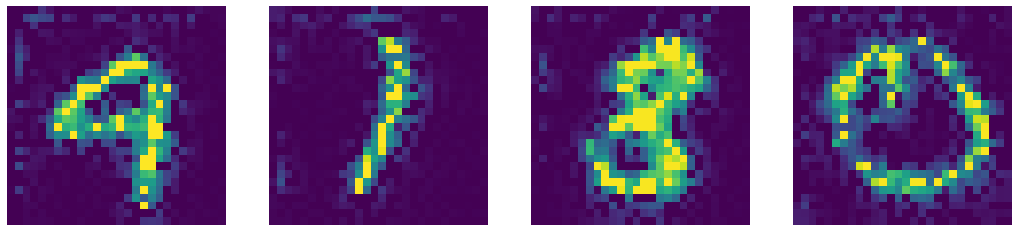


NS RECONSTRUCTED IMAGE


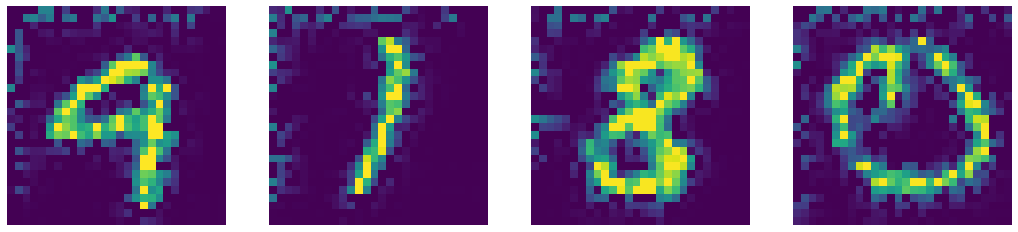

In [33]:
# Compare the results: [noise], [img + noise], [img], [AE, Telea, Navier-Stokes] inpainting

with torch.no_grad():
    print("ORIGINAL IMAGE")
    display_images(None, img[3:7])
    print("NOISE PATTERNS")
    display_images(None, noise[3:7])
    print("NOISY IMAGE")
    display_images(None, img_bad[3:7])
    
    print()
    print("AE OUTPUT RECONSTRUCTED IMAGE")
    display_images(None, output[3:7])
    
    print()
    print("TELEA RECONSTRUCTED IMAGE")
    display_images(None, TELEA)
    
    print()
    print("NS RECONSTRUCTED IMAGE")
    display_images(None, NS)

A basic trained denoisy AE performs better than the SOTA algorithms. This is true if we have examples with the noisy pattern to train the AE. **If the noisy change, you have to re-train your AE**. In other case, the AE is no longer valid.